In [1]:
# Code adapted from: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/ac5dcd03a40a08a8af7e1a67ade37f28cf88db43/ML/Pytorch/GANs/2.%20DCGAN/train.py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img+1, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.InstanceNorm2d(out_channels, affine=True), 
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim = 1) # N, channels, img height, img width
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(
        self,
        channels_noise,
        channels_img,
        features_g,
        num_classes,
        img_size,
        embed_size
        ):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size) #embedding needs to be added to noise

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        # latent vecotr z: N x noise_dim x 1 x 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim = 1)
        return self.net(x)

In [4]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def gradient_penalty(critic, labels, real, fake, device="cuda"):
    BATCH_SIZE, C, H, W = real.shape
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    if real.shape != fake.shape:
        print("not same shape")
    interpolated_images = real * epsilon + fake * (1-epsilon) #interpolape epsilon % real image, (1-epsilon fake image)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # compute grad of mixed scores w.r.t interpolated image
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [6]:
# # Need to override __init__, __len__, __getitem__
# # as per datasets requirement
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path, bad_path, transform=None, label_transform=None, shape = (100,100)):
        self.paths = [] # create a list to hold all paths read from file
        self.path_labels = []
        
        # load  the "good" paths (Class 1)
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=int).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                self.path_matrix = self.convert_path(shape, self.path)
                
                self.paths.append(self.path_matrix) # add the path to paths list
                self.path_labels.append(1)

        # load  the "bad" paths (Class 0)
        for filename in os.listdir(bad_path):
            with open(os.path.join(bad_path, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=int).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                self.path_matrix = self.convert_path(shape, self.path)
                
                self.paths.append(self.path_matrix) # add the path to paths list
                self.path_labels.append(0)

        self.transform = transform
        self.label_transform = label_transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir
            
        path_mat[path[path.shape[0]-1,1], path[path.shape[0]-1,0]] = 1     # Include the last point in the path

        return path_mat

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = np.float32(self.paths[idx])
        label = torch.tensor(self.path_labels[idx])

        if self.transform:
            x = self.transform(x).cuda()

        if self.label_transform:
            label = self.label_transform(label).cuda()

        return x, label

        #return image, label

In [7]:
# # Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 200
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64
FEATURES_GEN = 64

NUM_CLASSES = 10
GEN_EMBEDDING = 100

#Speicific to WGAN
CRITIC_ITERATIONS = 5 # how many times the critic loop runs for each generator loop
LAMBDA_GP = 10

# if we load from file this will be set to the loaded epoch
epoch_loaded = 0

In [8]:
transforms = tfms.Compose(
    [
        # tfms.ToPILImage(),
        # tfms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        tfms.ToTensor(),
        tfms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)


In [9]:
label_transforms = tfms.Compose(
    [
        # tfms.ToTensor(),
    ]
)

In [10]:
# If you train on MNIST, remember to set channels_img to 1
# dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
#                        download=True)

In [11]:
# comment mnist above and uncomment below if train on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)

dataset = PathsDataset(path = "./data/map_64x64/", bad_path="./data/map_64x64_bad/", shape = (64,64), transform=transforms, label_transform=label_transforms)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# If you train on MNIST, remember to set channels_img to 1
# dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
#                        download=True)

# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


Done!


In [12]:

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE, GEN_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC, NUM_CLASSES, IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

class: 0
cuda:0
cuda:0


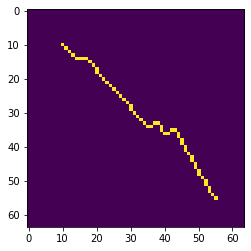

In [13]:
# for file in range(100):
#     image = dataset[file][0].cpu()
#     plt.figure()
#     plt.imshow(image)
idx = 20000
image = dataset[idx][0][0].cpu()
plt.imshow(image)
print(f'class: {dataset[idx][1]}')
print(dataset[idx][0][0].device)
print(dataset[idx][1].device)

In [14]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas = (0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas = (0.0, 0.9))

In [15]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [16]:
gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
  (embed): Embedding(10

In [23]:
gen_path = "./checkpoints/conditional/generator/"
disc_path = "./checkpoints/conditional/discriminator/"
loaded = 0 # if we haven't loaded from file
for epoch in range(NUM_EPOCHS):
    if epoch_loaded !=0 and loaded == 0:
        print(f'loaded from file. On epoch: {epoch_loaded}')
        loaded = 1
        epoch = epoch_loaded
    for batch_idx, (real, labels) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise, labels)
        labels = labels.to(device)

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic, labels, real, fake, device=device) # compute the gradient penalty
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp
            ) #   want to maximize (according to paper) but 
                                                                            #   optim algorithms are for minimizing so take - 
            critic.zero_grad()
            loss_critic.backward(retain_graph=True) # want to re use the computations for fake for generator
            opt_critic.step()

        ### Training generator: min E(critic(gen_fake))
        output = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()        

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:BATCH_SIZE], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:BATCH_SIZE], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            # save generator checkpoint
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': gen.state_dict(),
                        'optimizer_state_dict': opt_gen.state_dict(),
                        'loss': loss_gen,
            }, gen_path + "epoch-" + str(epoch) + "_batch-" + str(batch_idx) + ".tar")

            # save discriminator checkpoint
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': critic.state_dict(),
                        'optimizer_state_dict': opt_critic.state_dict(),
                        'loss': loss_critic,
            }, disc_path + "epoch-" + str(epoch) + "_batch-" + str(batch_idx) + ".tar")

            step += 1

loaded from file. On epoch: 7
Epoch [7/50] Batch 0/200                   Loss D: -9.8945, loss G: 44.4327


KeyboardInterrupt: 

In [77]:
# gen real and fake
label = 0
noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
fake = gen(noise, torch.tensor([label], dtype=torch.int32, device=device))

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]]],
       device='cuda:0', grad_fn=<TanhBackward0>)


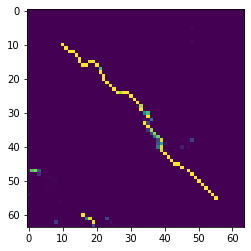

In [78]:
plt.imshow(fake.cpu().detach().numpy()[0][0])
print(fake)

In [72]:
output = critic(fake, torch.tensor([3], dtype=torch.int32, device=device)).reshape(-1)
print(output)

tensor([39.2119], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


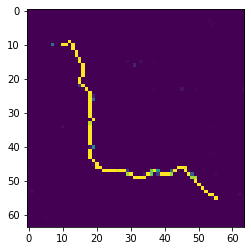

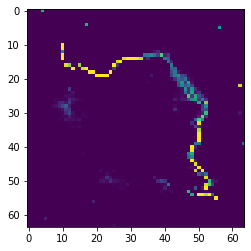

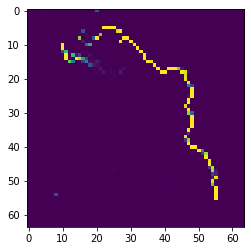

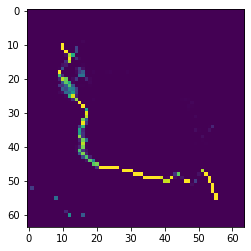

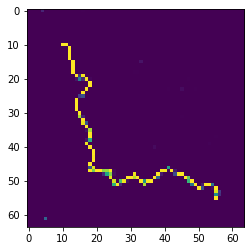

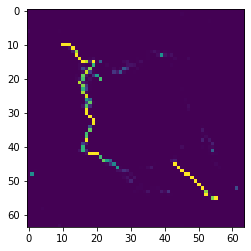

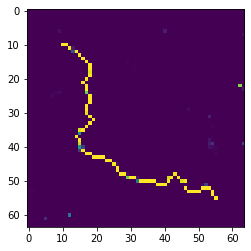

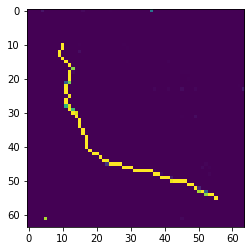

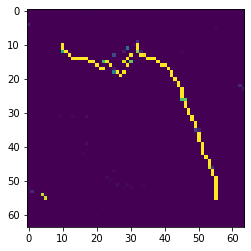

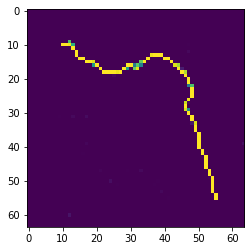

In [58]:
# gen 10 good
for idx in range(10):
    label = 1 # good path = 1
    noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
    fake = gen(noise, torch.tensor([label], dtype=torch.int32, device=device))
    # filename = "path_"+str(idx)+"_.txt"
    # np.savetxt(filename, image, delimiter=',')
    plt.figure()
    plt.imshow(fake.cpu().detach().numpy()[0][0])

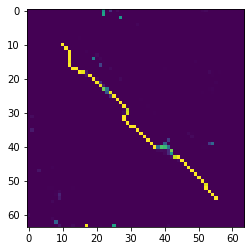

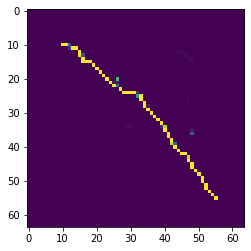

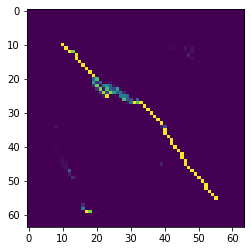

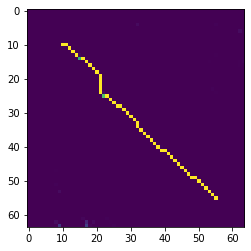

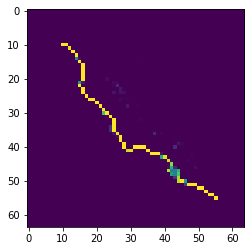

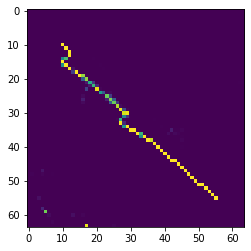

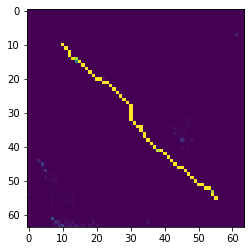

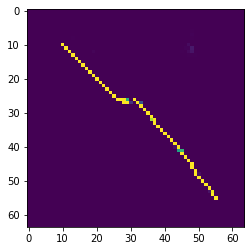

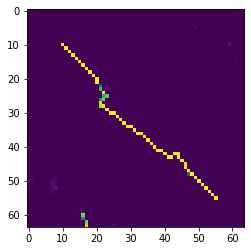

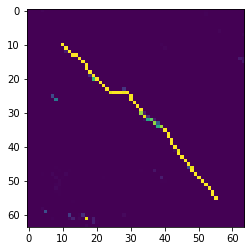

In [59]:
# gen 10 bad
for idx in range(10):
    label = 0 # bad path = 0
    noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
    fake = gen(noise, torch.tensor([label], dtype=torch.int32, device=device))
    # filename = "path_"+str(idx)+"_.txt"
    # np.savetxt(filename, image, delimiter=',')
    plt.figure()
    plt.imshow(fake.cpu().detach().numpy()[0][0])

In [45]:
#load gen from file
gen_path = "./checkpoints/conditional/generator/"

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE, GEN_EMBEDDING).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas = (0.0, 0.9))

checkpoint_gen = torch.load(gen_path+"epoch-49_batch-700.tar")
gen.load_state_dict(checkpoint_gen['model_state_dict'])
opt_gen.load_state_dict(checkpoint_gen['optimizer_state_dict'])
epoch_loaded = checkpoint_gen['epoch']
loss = checkpoint_gen['loss']


#load critic from fle
disc_path = "./checkpoints/conditional/discriminator/"

critic = Discriminator(CHANNELS_IMG, FEATURES_DISC, NUM_CLASSES, IMAGE_SIZE).to(device)
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas = (0.0, 0.9))

checkpoint_critic = torch.load(disc_path+"epoch-49_batch-700.tar")
critic.load_state_dict(checkpoint_critic['model_state_dict'])
opt_critic.load_state_dict(checkpoint_critic['optimizer_state_dict'])
epoch = checkpoint_critic['epoch']
loss = checkpoint_critic['loss']


# train or eval()
# gen.eval()
# critic.eval()
# - or -
gen.train()
critic.train()

print(epoch_loaded)

49
